<a href="https://colab.research.google.com/github/yasemingunindi/nma-pupil-decoder/blob/main/pupil_decoder_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decoding Eye Movements in V1: Magical Mouse’s Pupil Decoder


**Authors**: Yasemin Gunindi, Max Wassermann, Devashri Deulkar

**Date**: February, 2024  

**Description**:
- Investigating the neural representation of eye movements in primary visual cortex (V1), inspired by the findings of Stringer et al. (https://doi.org/10.1126/science.aav7893).
- Key questions: Do neural activities predict eye movements before or after their occurrence? Which cortical depths encode eye movements most effectively?
- Methodology: Utilizing a Linear Regression model with Principal Component Analysis (PCA) featuring 100 components.
- Findings: Comparative analysis of explained variance scores sheds light on the neural encoding of eye movements in V1.


#This first part is included in Neuromatch Academy's template.

## Loading of Stringer spontaneous data

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details.
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other.
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['run']))

(11983, 7018)
7018


In [ ]:
print(dat['sresp'][1].max())
print(dat['sresp'][0].max())

84.170944
52.054565


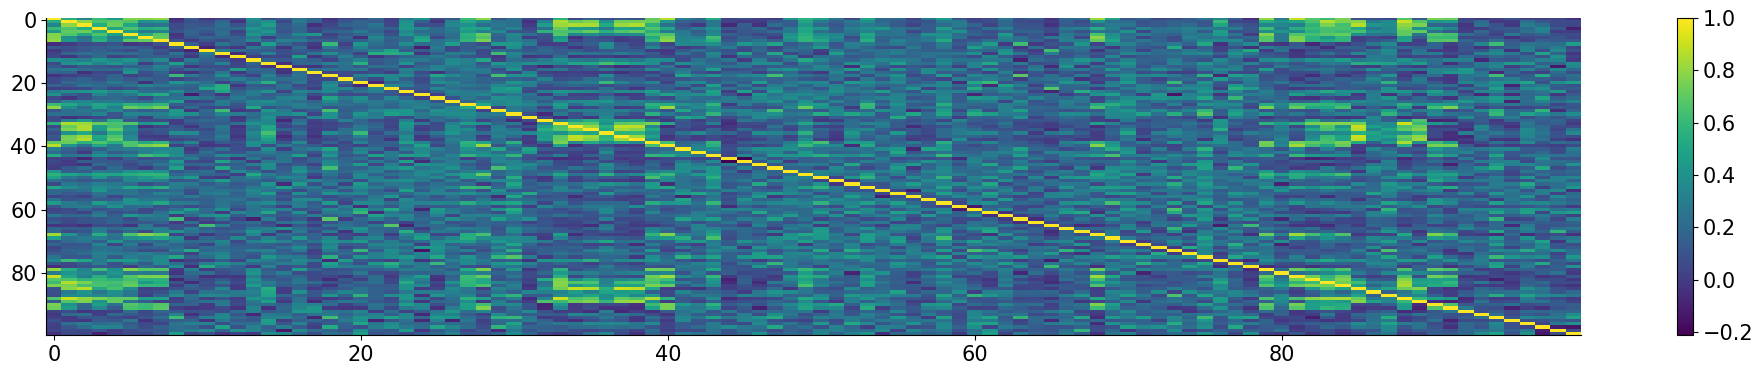

In [ ]:
import seaborn as sns
import pandas as pd
# Compute the correlation matrix for all columns
# Convert the numpy array to a pandas DataFrame
sresp_df = pd.DataFrame(dat['sresp'][0:100,0:100])
corr_matrix = sresp_df.corr()
plt.imshow(corr_matrix, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()



In [ ]:
# @title Dimension of each variable
print('Neural Activity:   ', dat['sresp'].shape)
print('Neron Stats:  ', dat['stat'].shape)
print('Neron Position:  ', dat['xyz'].shape)
print('Pupil Area:  ', dat['pupilArea'].shape)
print('Pupil Position:  ', dat['pupilCOM'].shape)
print('Face SVD:   ',dat['beh_svd_time'].shape)
print('Face SVD Mask:   ',dat['beh_svd_mask'].shape)
print('Running Speed:  ', dat['run'].shape)


Neural Activity:    (11983, 7018)
Neron Stats:   (11983, 1)
Neron Position:   (3, 11983)
Pupil Area:   (7018, 1)
Pupil Position:   (7018, 2)
Face SVD:    (7018, 1000)
Face SVD Mask:    (240, 320, 1000)
Running Speed:   (7018, 1)


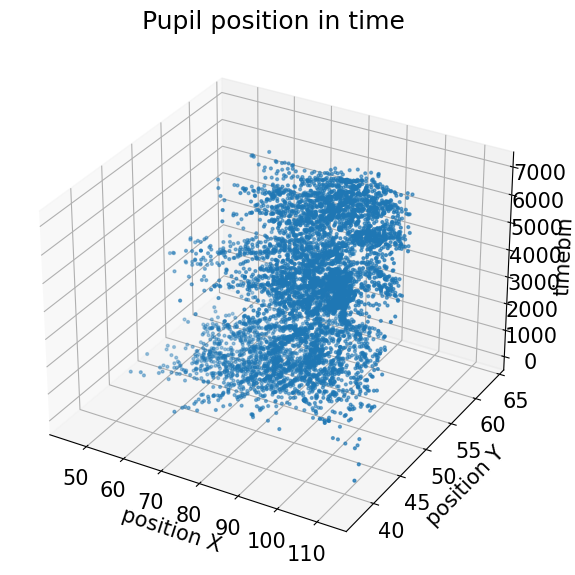

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y = dat['pupilCOM'].T
z = np.linspace(0, 7018, 7018)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4)
ax.set(title = 'Pupil position in time', xlabel='position X', ylabel='position Y', zlabel='timebin')
plt.show()

<ipython-input-11-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


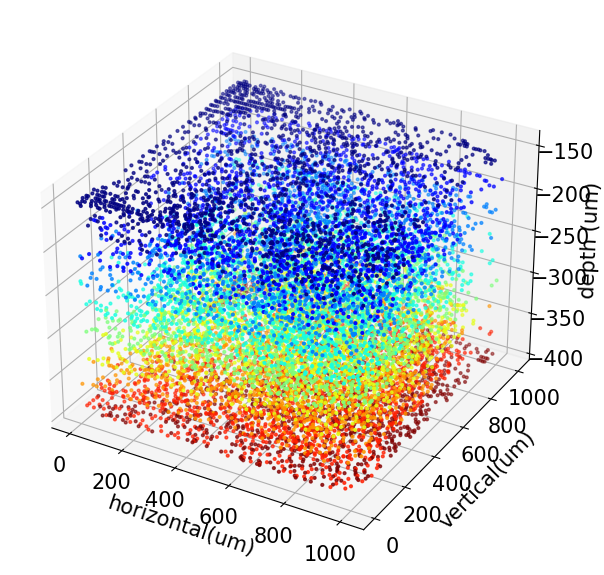

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

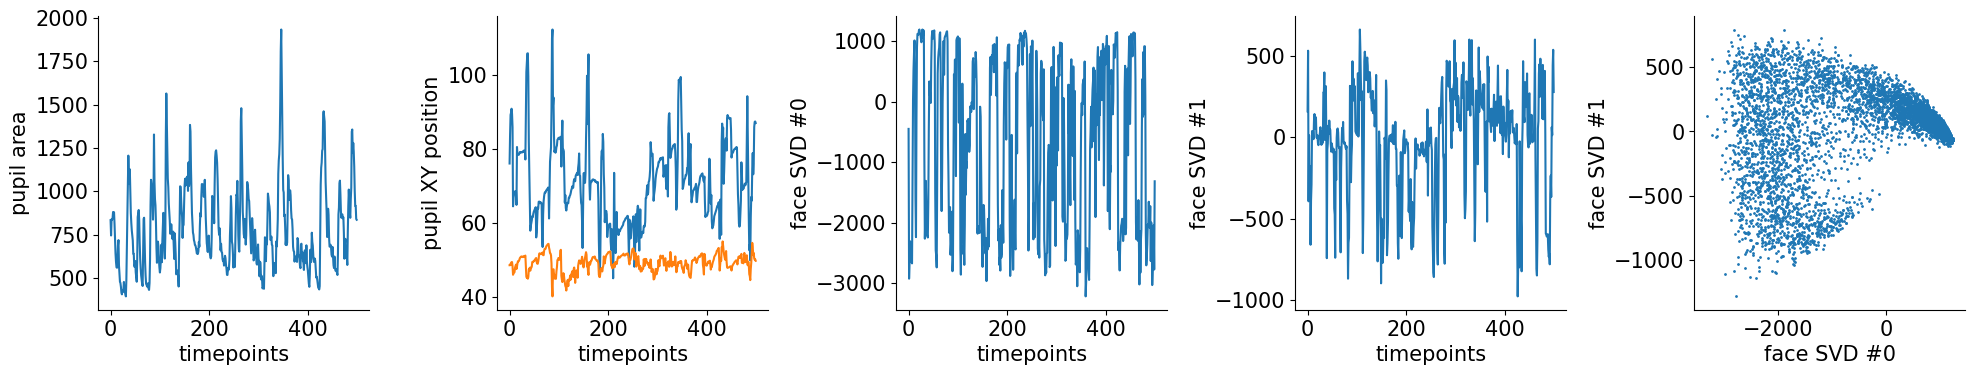

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

#Starting here the code belongs to  authors.

#Imports

In [ ]:
import numpy as np
import statsmodels.api as sm
import random as rnd
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import levene

#Preparing Data

##Normalize and Subset Neural Data

In [ ]:
# @markdown Neural data is subsetted to 9 layers  according to depth information and normalized.
Z = zscore(dat['sresp'], axis=1)
def unique(list1):
    list_set = set(list1)
    unq = (list(list_set))
    return unq
depth_values = unique(dat['xyz'][2].tolist())
depth_subsets = {}
layer = 0
for depth in depth_values:
    layer = layer + 1
    depth_indices = []
    depth_indices = (dat['xyz'][2] == depth)
    depth_subsets[layer] = Z[depth_indices]

    print(f'Layer {layer} at depth {depth} has {len(depth_subsets[layer])} neurons.')

Layer 1 at depth -150.0 has 1131 neurons.
Layer 2 at depth -180.0 has 1183 neurons.
Layer 3 at depth -210.0 has 1218 neurons.
Layer 4 at depth -240.0 has 1321 neurons.
Layer 5 at depth -270.0 has 1415 neurons.
Layer 6 at depth -300.0 has 1471 neurons.
Layer 7 at depth -330.0 has 1418 neurons.
Layer 8 at depth -360.0 has 1440 neurons.
Layer 9 at depth -390.0 has 1386 neurons.


##Behavioral Data

In [ ]:
#dat['pupilCOM']: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
# @markdown Nan values are filled. Direction of Relative Change is the normalized vector of relative change. Distance is euclidean distance. Relative change in pupil position is calculated. First value at time bin 0 is assigned as (0,0)
x_change = np.diff(dat['pupilCOM'][:,0])
y_change = np.diff(dat['pupilCOM'][:,1])
y = np.vstack((x_change,y_change)).T
y = np.vstack((np.array([0,0]), y))
rc = np.nan_to_num(y)
D = np.sqrt(x_change**2 + y_change**2)
D = np.concatenate(([0], D))
dist = np.nan_to_num(D)
dir = preprocessing.normalize(np.nan_to_num(y))
ap = np.nan_to_num(dat['pupilCOM'])

##Creating DataFrame

In [ ]:
columns = {
    "Eye_Mov": [],
    "TimeBin": [],
    "Depth": [],
    "TimeSplit": [],
    "MAE": [],
    "MSE": [],
    "MedianE": [],
    "R2": [],
    "Exp_Var": []
}
df = pd.DataFrame(columns)

##Function for Eye Movement Aspect

In [ ]:
def asp_to_str(i, dir, dist, ap, rc):
    aspect = ""

    if np.array_equal(i, dir):
        aspect = "Direction"
    elif np.array_equal(i, dist):
        aspect = "Magnitude"
    elif np.array_equal(i, rc):
        aspect = "RelativeChange"
    elif np.array_equal(i, ap):
        aspect = "AbsolutePosition"

    return aspect

#Testing Magnitude, Direction, Relative Change, Absolute Position

In [29]:
#Ocular Motion Aspects
asp = [dir,dist,ap,rc]
for k in asp:
  Y = k
  a = asp_to_str(k,dir,dist,ap,rc)
  print(a)
  #Cortical Depth
  for i in range(9):
    depth = i+1
    X = np.nan_to_num(depth_subsets[depth].T)
    #Time Gaps
    gaps = [-1,0,1]
    for n, gap in enumerate(gaps):
      if gap < 0:
        X_shifted = X[:gap]
        Y_shifted = Y[-gap:]
      elif gap > 0:
        X_shifted = X[gap:]
        Y_shifted = Y[:-gap]
      else:
        X_shifted = X
        Y_shifted = Y
      #Principal Component Analysis
      pca = PCA(n_components=100)
      X_pca = pca.fit_transform(X_shifted)
      dist_var = []
      s = 0
      #Time Split
      tscv = TimeSeriesSplit(n_splits=10, gap=0)
      for train_ix, test_ix in tscv.split(X_pca):
        X_train = X_pca[train_ix]
        X_test = X_pca[test_ix]
        y_train = Y_shifted[train_ix]
        y_test = Y_shifted[test_ix]

        #GLM model
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)


        #Evaluate the performance of the best model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        medianae = median_absolute_error(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)

        #Append Performances
        df = pd.concat([df, pd.DataFrame({"Eye_Mov": [a], "TimeBin": [gap], "Depth": [depth], "TimeSplit": [s], "MAE": [mae], "MSE": [mse], "MedianE": [medianae], "Exp_Var": [evs], "R2": [r2]})], ignore_index=True)

        s = s+1


Direction
Magnitude
AbsolutePosition
RelativeChange


##Raw Data to CSV

In [ ]:
df.to_csv("Stringer.csv")

#Analysis and Visualization

In [ ]:
raw_df = pd.read_csv('Stringer.csv')
df = raw_df[raw_df['TimeSplit'] > 4] #Half of time splits are removed
df = df.iloc[:, 1:]
rc_df = df[df['Eye_Mov'] =='RelativeChange'] #First, analysis is conducted on RC

df.to_csv("Stringer_RemovedSplits.csv", index=False)
rc_df.to_csv("Stringer_RC_RemovedSplits.csv", index=False)

##Depth

<ipython-input-21-9412a3151cd5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Depth', y='Exp_Var', data=rc_df, palette=colors)


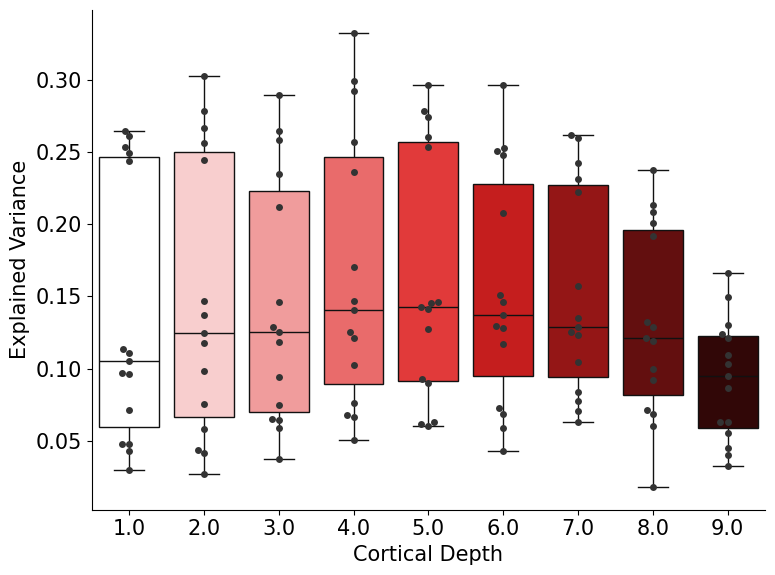

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
# Define the base color
base_color = '#fe7676'
base_rgb = sns.color_palette([base_color])[0]
num_depths = 9
colors = []
for i in range(num_depths):
    brightness = 1 - (i / num_depths)
    color = sns.set_hls_values(base_rgb, l=brightness)
    colors.append(color)

ax = sns.boxplot(x='Depth', y='Exp_Var', data=rc_df, palette=colors)
sns.swarmplot(x='Depth', y='Exp_Var', data=rc_df, color="#333333", ax=ax)
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Cortical Depth")
plt.show()

In [ ]:
# @title Statistical test for Cortical Depths in Relative Change
depth_grouped = rc_df.groupby('Depth')['Exp_Var']
depth_groups = [group.tolist() for _, group in depth_grouped]

# Conducting Levene's test
statistic, p_value = levene(*depth_groups)

print("Levene's Test Statistic:", statistic)
print("p-value:", p_value)
alpha = 0.05
if p_value > alpha:
    print("Variances are equal. Proceed with ANOVA.")
else:
    print("Levene's test is violated. Variances are not equal. Proceed with alternative analysis.")

# Conducting the Kruskal-Wallis test
statistic, p_value = f_oneway(*depth_groups)

if p_value > alpha:
  print("Failed to reject the null hypothesis. No significant difference between groups.")
else:
  print("Reject the null hypothesis. Significant difference between groups.")
  print("Kruskal-Wallis Test Statistic:", statistic)
  if p_value < 0.001:
    print("p-value < .001")
  else:
    print("p-value < .05")


Levene's Test Statistic: 1.050123180698611
p-value: 0.4024662338900723
Variances are equal. Proceed with ANOVA.
Failed to reject the null hypothesis. No significant difference between groups.


##Time Gap

<ipython-input-23-4ad8a86a323f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Neural data\n precedes behavior", "Neural data\n concurrent with behavior", "Neural data\n postdates behavior"])


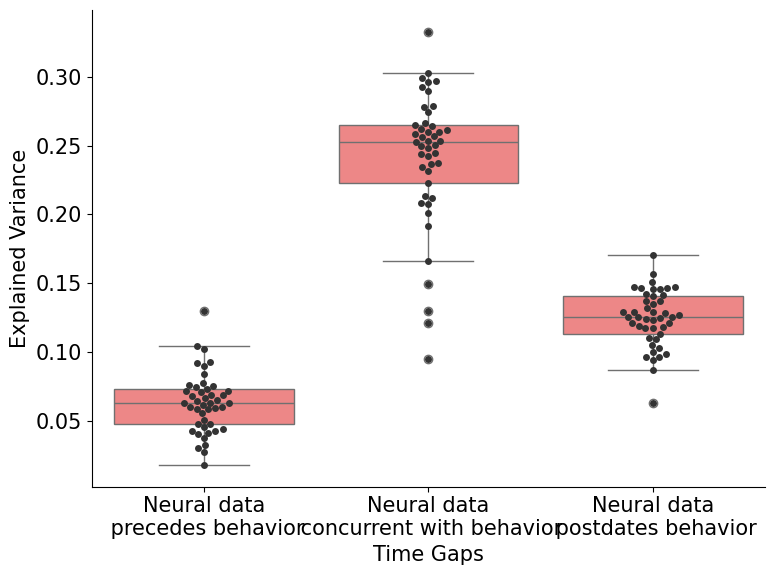

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x='TimeBin', y='Exp_Var', data =rc_df, color='#fe7676')
ax = sns.swarmplot(x='TimeBin', y='Exp_Var', data = rc_df, color="#333333")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Time Gaps")
ax.set_xticklabels(["Neural data\n precedes behavior", "Neural data\n concurrent with behavior", "Neural data\n postdates behavior"])
plt.show()

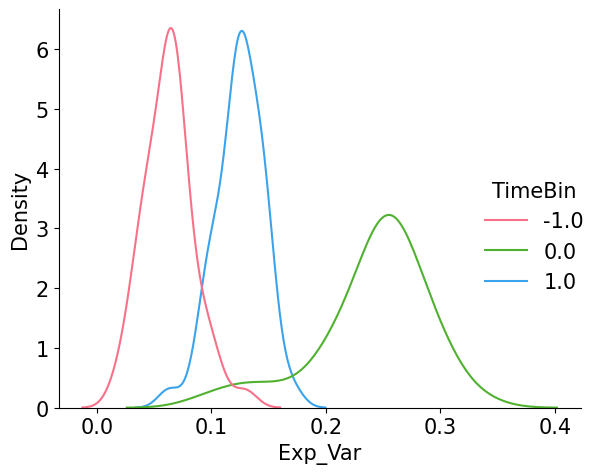

In [ ]:
color = sns.color_palette("husl", 3)
sns.displot(rc_df, x="Exp_Var", hue="TimeBin", kind="kde", palette = color)

In [ ]:
# @title Statistical test for Time Gaps in Relative Change
time_grouped = rc_df.groupby('TimeBin')['Exp_Var']
time_groups = [group.tolist() for _, group in time_grouped]

# Conducting Levene's test
statistic, p_value = levene(*time_groups)
print("Levene's Test Statistic:", statistic)
print("p-value:", p_value)
alpha = 0.05
if p_value > alpha:
    print("Variances are equal. Proceed with ANOVA.")
else:
    print("Levene's test is violated. Variances are not equal. Proceed with alternative analysis.")

# Conducting the Kruskal-Wallis test
statistic, p_value = kruskal(*time_groups)
alpha = 0.05
if p_value > alpha:
  print("Failed to reject the null hypothesis. No significant difference between groups.")
else:
  print("Reject the null hypothesis. Significant difference between groups.")
  print("Kruskal-Wallis Test Statistic:", statistic)
  if p_value < 0.001:
    print("p-value < .001")
  else:
    print("p-value < .05")

Levene's Test Statistic: 8.24581978700521
p-value: 0.0004222282540262272
Levene's test is violated. Variances are not equal. Proceed with alternative analysis.
Reject the null hypothesis. Significant difference between groups.
Kruskal-Wallis Test Statistic: 109.73597676107477
p-value < .001


## Eye Movement Aspects

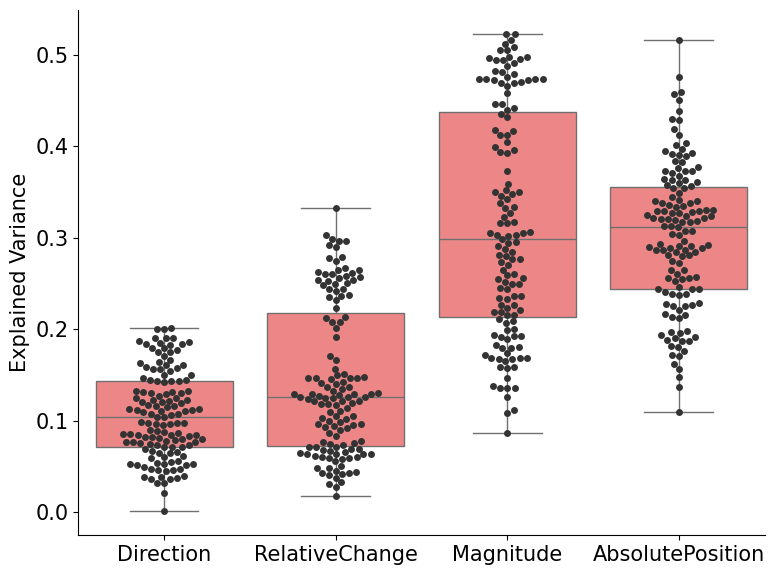

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
order = ['Direction', 'RelativeChange', 'Magnitude', 'AbsolutePosition']
ax = sns.boxplot(x='Eye_Mov', y='Exp_Var', data =df, color='#fe7676', order=order)
ax = sns.swarmplot(x='Eye_Mov', y='Exp_Var', data = df, color="#333333",  order=order)
ax.set_ylabel("Explained Variance")
ax.set_xlabel("")
plt.show()

In [ ]:
# @title Statistical test for different Eye Movement Aspects
time_grouped = df.groupby('Eye_Mov')['Exp_Var']
time_groups = [group.tolist() for _, group in time_grouped]

# Conducting Levene's test
statistic, p_value = levene(*time_groups)
print("Levene's Test Statistic:", statistic)
print("p-value:", p_value)
alpha = 0.05
if p_value > alpha:
    print("Variances are equal. Proceed with ANOVA.")
else:
    print("Levene's test is violated. Variances are not equal. Proceed with alternative analysis.")

# Conducting the Kruskal-Wallis test
statistic, p_value = kruskal(*time_groups)
alpha = 0.05
if p_value > alpha:
  print("Failed to reject the null hypothesis. No significant difference between groups.")
else:
  print("Reject the null hypothesis. Significant difference between groups.")
  print("Kruskal-Wallis Test Statistic:", statistic)
  if p_value < 0.001:
    print("p-value < .001")
  else:
    print("p-value < .05")

Levene's Test Statistic: 40.48584795033463
p-value: 1.3537672806084023e-23
Levene's test is violated. Variances are not equal. Proceed with alternative analysis.
Reject the null hypothesis. Significant difference between groups.
Kruskal-Wallis Test Statistic: 308.7273337745221
p-value < .001
